# Spatio-temporal zonal analysis

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

import pylandstats as pls

In order to perform zonal analyses over time, PyLandStats features an additional `SpatioTemporalZonalAnalysis` analysis class - as well as `SpatioTemporalBufferAnalysis` and `SpatioTemporalZonalGridAnalysis`.

Like in the [spatio-temporal analysis example](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/02-spatiotemporal-analysis.ipynb), we will use the three extracts of [Veveyse district](https://en.wikipedia.org/wiki/Veveyse_District) from the [Swiss Land Statistics (SLS) datasets from the Swiss Federal Statistical Office](https://www.bfs.admin.ch/bfs/en/home/services/geostat/swiss-federal-statistics-geodata/land-use-cover-suitability/swiss-land-use-statistics.html) for the years 1992, 2004 and 2012, yet in this case we also need to specify how the buffers are constructed. 

We first need to run the cell below so that:
- the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).
- the elevation zones vector data is downloaded and preprocessed (see [A04-elev-zones.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A04-elev-zones.ipynb) for more details).

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile lulc_tifs elev_zones

## Spatio-temporal zonal analysis

Besides the base LULC maps, we will use a geopackage file defining a set of elevation zones. Like with the `ZonalAnalysis` class, we can use the `zone_index` argument to indicate which column of the geopackage file will be used to index the zones:

In [ ]:
URBAN_CLASS_VAL = 1
input_filepaths = [
    "../data/processed/veveyse-AS97R_4.tif",
    "../data/processed/veveyse-AS09R_4.tif",
    "../data/processed/veveyse-AS18_4.tif",
]
years = ["1992", "2004", "2012"]
elev_zones_filepath = "../data/processed/elev-zones.gpkg"

stza = pls.SpatioTemporalZonalAnalysis(
    input_filepaths, elev_zones_filepath, zone_index="elev-zone", dates=years
)

Like `SpatioTemporalAnalysis`, `BufferAnalysis` and/or `ZonalAnalysis`, we can compute the data frame of class metrics through the `compute_class_metrics_df` method:

In [ ]:
class_metrics_df = stza.compute_class_metrics_df()
class_metrics_df.head()

metric                    total_area proportion_of_landscape  \
elev-zone class_val dates                                      
<1000     1         1992       680.0                8.369231   
                    2004       786.0                9.673846   
                    2012       911.0               11.212308   
          2         1992      5851.0               72.012308   
                    2004      5740.0               70.646154   

metric                    number_of_patches patch_density largest_patch_index  \
elev-zone class_val dates                                                       
<1000     1         1992              250.0      3.076923            0.984615   
                    2004              249.0      3.064615            1.144615   
                    2012              232.0      2.855385            2.289231   
          2         1992               25.0      0.307692           68.996923   
                    2004               25.0      0.307692           67.766154   

metric                    total_edge edge_density landscape_shape_index  \
elev-zone class_val dates                                                 
<1000     1         1992    191300.0    23.544615             18.301887   
                    2004    205700.0    25.316923             18.315789   
                    2012    219200.0    26.978462             18.295082   
          2         1992    424900.0    52.295385             15.359477   
                    2004    437000.0    53.784615             15.842105   

metric                    effective_mesh_size   area_mn  ...  \
elev-zone class_val dates                                ...   
<1000     1         1992             1.531077      2.72  ...   
                    2004             2.305231  3.156627  ...   
                    2012             6.027446  3.926724  ...   
          2         1992          3870.990892    234.04  ...   
                    2004          3732.606277     229.6  ...   

metric                    fractal_dimension_md fractal_dimension_ra  \
elev-zone class_val dates                                             
<1000     1         1992                   1.0             0.197592   
                    2004                   1.0             0.206568   
                    2012                   1.0             0.217396   
          2         1992               1.00371             0.297869   
                    2004              1.011893              0.30188   

metric                    fractal_dimension_sd fractal_dimension_cv  \
elev-zone class_val dates                                             
<1000     1         1992              0.042256             4.130486   
                    2004              0.044102             4.300955   
                    2012              0.047073             4.585308   
          2         1992              0.073523             7.024782   
                    2004              0.076398             7.252821   

metric                    euclidean_nearest_neighbor_mn  \
elev-zone class_val dates                                 
<1000     1         1992                     278.554507   
                    2004                     274.304841   
                    2012                     274.938105   
          2         1992                     217.032108   
                    2004                     220.087837   

metric                    euclidean_nearest_neighbor_am  \
elev-zone class_val dates                                 
<1000     1         1992                     240.692873   
                    2004                      231.55464   
                    2012                     230.166944   
          2         1992                       200.2189   
                    2004                     200.306129   

metric                    euclidean_nearest_neighbor_md  \
elev-zone class_val dates                                 
<1000     1         1992                     223.606798   
       

Note that in this case, the data frame features a three-level [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.html) that distinguishes the computed value for each zone, class values, and date. Again, we can operate upon such data frames as we would do with any other pandas data frame. For instance, we might want to evaluate the difference between the proportion of landscape occupied of urban patches (represented by a `class_val` of 1) computed for the elevation zone of "<1000" and ">1500":

In [ ]:
(
    class_metrics_df.loc[("<1000", 1), "proportion_of_landscape"]
    - class_metrics_df.loc[(">1500", 1), "proportion_of_landscape"]
)

/tmp/ipykernel_102414/2158675103.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  class_metrics_df.loc[("<1000", 1), "proportion_of_landscape"]
/tmp/ipykernel_102414/2158675103.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  - class_metrics_df.loc[(">1500", 1), "proportion_of_landscape"]


dates
1992      7.94729
2004     9.251905
2012    10.790367
Name: proportion_of_landscape, dtype: object

Likewise in the other classes of PyLandStats, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must respectively pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods of `SpatioTemporalZonalAnalysis` as in:

In [ ]:
metrics = ["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
classes = [URBAN_CLASS_VAL]
metrics_kws = {
    "proportion_of_landscape": {"percent": False},
    "edge_density": {"count_boundary": True},
}
stza.compute_class_metrics_df(metrics=metrics, classes=classes, metrics_kws=metrics_kws)

metric                    proportion_of_landscape edge_density  \
elev-zone class_val dates                                        
<1000     1         1992                 0.083692    23.876923   
                    2004                 0.096738    25.698462   
                    2012                 0.112123    27.470769   
1000-1500 1         1992                 0.022135     6.925268   
                    2004                 0.023669     6.969099   
                    2012                 0.025641     7.232084   
>1500     1         1992                 0.004219     1.687764   
                    2004                 0.004219     1.687764   
                    2012                 0.004219     1.687764   

metric                    fractal_dimension_am  
elev-zone class_val dates                       
<1000     1         1992               1.08655  
                    2004              1.092837  
                    2012              1.119244  
1000-1500 1         1992              1.067187  
                    2004               1.06835  
                    2012              1.067263  
>1500     1         1992                   1.0  
                    2004                   1.0  
                    2012                   1.0

Another important functionality of the `SpatioTemporalZonalAnalysis` is plotting the time series of metrics at each zone. We can accomplish that through the `plot_metric` method. For instance, let us plot the proportion of landscape at the level of the *urban* class (`class_val` of 1):

<Axes: ylabel='PLAND'>

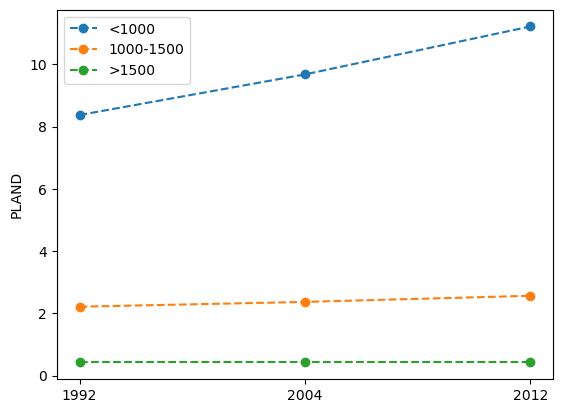

In [ ]:
stza.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

It can also be interesting to visualize such information in space by using `compute_zonal_statistics_gdf` method to obtain a geo-data frame:

In [ ]:
zonal_statistics_gdf = stza.compute_zonal_statistics_gdf(
    metrics, class_val=URBAN_CLASS_VAL
)
zonal_statistics_gdf

metric                     proportion_of_landscape  edge_density  \
elev-zone class_val dates                                          
<1000     1         1992                  8.369231     23.544615   
                    2004                  9.673846     25.316923   
                    2012                 11.212308     26.978462   
1000-1500 1         1992                  2.213456      6.837607   
                    2004                  2.366864      6.793776   
                    2012                  2.564103      7.056761   
>1500     1         1992                  0.421941      1.054852   
                    2004                  0.421941      1.054852   
                    2012                  0.421941      1.054852   

metric                     fractal_dimension_am  \
elev-zone class_val dates                         
<1000     1         1992               1.086550   
                    2004               1.092837   
                    2012               1.119244   
1000-1500 1         1992               1.067187   
                    2004               1.068350   
                    2012               1.067263   
>1500     1         1992               1.000000   
                    2004               1.000000   
                    2012               1.000000   

metric                                                              geometry  
elev-zone class_val dates                                                     
<1000     1         1992   MULTIPOLYGON (((2560900.000 1150500.000, 25607...  
                    2004   MULTIPOLYGON (((2560900.000 1150500.000, 25607...  
                    2012   MULTIPOLYGON (((2560900.000 1150500.000, 25607...  
1000-1500 1         1992   POLYGON ((2563900.000 1160700.000, 2563900.000...  
                    2004   POLYGON ((2563900.000 1160700.000, 2563900.000...  
                    2012   POLYGON ((2563900.000 1160700.000, 2563900.000...  
>1500     1         1992   MULTIPOLYGON (((2566300.000 1151500.000, 25665...  
                    2004   MULTIPOLYGON (((2566300.000 1151500.000, 25665...  
                    2012   MULTIPOLYGON (((2566300.000 1151500.000, 25665...

Since now we have a time series of values, we can spatially plot the evolution of the metrics at each zone:

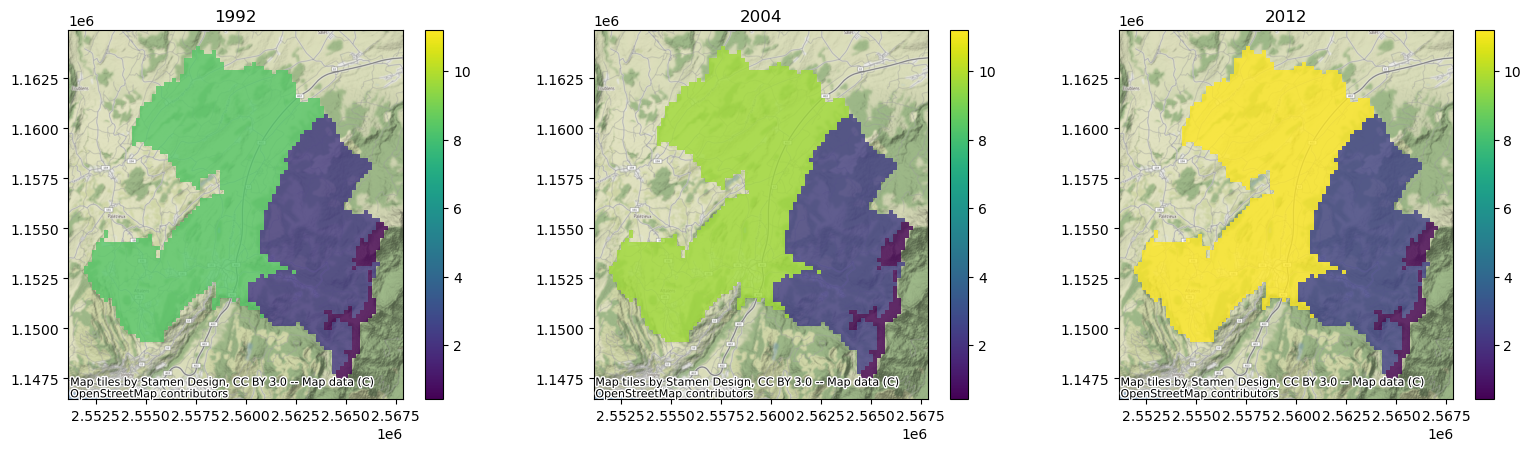

In [ ]:
num_years = len(years)
figwidth, figheight = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, num_years, figsize=(num_years * figwidth, figheight))

# get min and max values for all years to have the same scale accross plots
vmin = zonal_statistics_gdf["proportion_of_landscape"].min()
vmax = zonal_statistics_gdf["proportion_of_landscape"].max()
for year, ax in zip(years, axes):
    zonal_statistics_gdf.loc[:, URBAN_CLASS_VAL, year].plot(
        "proportion_of_landscape", ax=ax, alpha=0.8, legend=True, vmin=vmin, vmax=vmax
    )
    ax.set_title(year)
    cx.add_basemap(ax, crs=zonal_statistics_gdf.crs)

In fact, we can apply any transformation to the geo-data frame to visualize the metrics as required. For instance, we can "unstack" the data frame to have separate columns for each year (how this is accomplished is beyond the scope of this tutorial), so that we can plot all the metrics values in the map:

In [ ]:
plot_gdf = zonal_statistics_gdf.drop("geometry", axis=1).unstack()
plot_gdf.columns = plot_gdf.columns.to_flat_index().map(lambda tup: "-".join(tup))
plot_gdf = gpd.GeoDataFrame(
    plot_gdf,
    geometry=plot_gdf.reset_index()["elev-zone"].map(stza.zone_gser).values,
    crs=stza.zone_gser.crs,
)
plot_gdf.explore()

## Spatiotemporal buffer analysis

Let us now consider three buffers of 2, 4 and 6km around the center of the town of Chatel-St-Denis. We can explore how landscape metrics at such extents change through times by using the `SpatioTemporalBufferAnalysis` class as in:

In [ ]:
# latitude and longitude of the center of Chatel-St-Denis according to OpenStreetMap
base_geom = Point(6.8992073, 46.52634)
base_geom_crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# buffer distances (in meters)
buffer_dists = [2000, 4000, 6000]

stba = pls.SpatioTemporalBufferAnalysis(
    input_filepaths, base_geom, buffer_dists, base_geom_crs=base_geom_crs, dates=years
)

Analogously to `BufferAnalysis`, we could also initialize the from a polygon geometry (such an administrative boundary) by passing such object as the `base_geom` argument. See [the zonal analysis notebook](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/03-zonal-analysis.ipynb) to see how this can be done

The functionalities of `SpatioTemporalBufferAnalysis` are essentially the same as those of `SpatioTemporalZonalAnalysis` reviewed above:

In [ ]:
class_metrics_df = stba.compute_class_metrics_df()
class_metrics_df.head()

metric                      total_area proportion_of_landscape  \
buffer_dist class_val dates                                      
2000        1         1992       205.0               17.672414   
                      2004       245.0                21.12069   
                      2012       281.0               24.224138   
            2         1992       741.0                63.87931   
                      2004       698.0               60.172414   

metric                      number_of_patches patch_density  \
buffer_dist class_val dates                                   
2000        1         1992               38.0      3.275862   
                      2004               34.0      2.931034   
                      2012               25.0      2.155172   
            2         1992                7.0      0.603448   
                      2004                7.0      0.603448   

metric                      largest_patch_index total_edge edge_density  \
buffer_dist class_val dates                                               
2000        1         1992             6.982759    45100.0     38.87931   
                      2004             8.103448    48900.0    42.155172   
                      2012            16.465517    50900.0     43.87931   
            2         1992            49.051724    71400.0    61.551724   
                      2004            46.465517    73800.0     63.62069   

metric                      landscape_shape_index effective_mesh_size  \
buffer_dist class_val dates                                             
2000        1         1992               7.896552            6.723276   
                      2004                7.78125            9.961207   
                      2012               7.647059           32.356034   
            2         1992               7.527273          300.950862   
                      2004               8.018868          259.891379   

metric                          area_mn  ... fractal_dimension_md  \
buffer_dist class_val dates              ...                        
2000        1         1992     5.394737  ...             1.005947   
                      2004     7.205882  ...             1.011893   
                      2012        11.24  ...             1.011893   
            2         1992   105.857143  ...             1.050162   
                      2004    99.714286  ...             1.107502   

metric                      fractal_dimension_ra fractal_dimension_sd  \
buffer_dist class_val dates                                             
2000        1         1992              0.184165             0.049826   
                      2004              0.178114             0.053776   
                      2012              0.220343             0.058504   
            2         1992              0.228923             0.092117   
                      2004              0.236814             0.087711   

metric                      fractal_dimension_cv  \
buffer_dist class_val dates                        
2000        1         1992              4.818704   
                      2004              5.172022   
                      2012              5.599764   
            2         1992              8.490666   
                      2004              7.929402   

metric                      euclidean_nearest_neighbor_mn  \
buffer_dist class_val dates                                 
2000        1         1992                     254.487263   
                      2004                     237.507684   
                      2012                     253.663519   
            2         1992                          200.0   
                      2004                     214.285714   

metric                      euclidean_nearest_neighbor_am  \
buffer_dist class_val dates                                 
2000        1         1992                     222.764975   
                      2004                     212.264388   
                      20

In [ ]:
stba.compute_landscape_metrics_df()

metric             total_area  number_of_patches  patch_density  \
buffer_dist dates                                                 
2000        1992       1160.0               94.0       8.103448   
            2004       1160.0               93.0       8.017241   
            2012       1160.0               84.0       7.241379   
4000        1992       3685.0              219.0       5.943012   
            2004       3685.0              214.0       5.807327   
            2012       3685.0              199.0       5.400271   
6000        1992       7195.0              396.0       5.503822   
            2004       7195.0              385.0       5.350938   
            2012       7195.0              375.0       5.211953   

metric             largest_patch_index  total_edge  edge_density  \
buffer_dist dates                                                  
2000        1992             49.051724     79600.0     68.620690   
            2004             46.465517     83200.0     71.724138   
            2012             43.793103     84700.0     73.017241   
4000        1992             48.032564    225100.0     61.085482   
            2004             46.947083    230600.0     62.578019   
            2012             45.210312    234900.0     63.744912   
6000        1992             48.644892    428400.0     59.541348   
            2004             47.713690    432700.0     60.138985   
            2012             46.309937    437600.0     60.820014   

metric             landscape_shape_index  effective_mesh_size   entropy  \
buffer_dist dates                                                         
2000        1992                7.086957           311.250000  1.385050   
            2004                7.347826           273.368966  1.457972   
            2012                7.456522           264.284483  1.491411   
4000        1992               10.815574           973.771777  1.344319   
            2004               11.040984           890.491452  1.391068   
            2012               11.217213           836.093080  1.427391   
6000        1992               14.470588          2051.480890  1.335630   
            2004               14.597059          1976.238360  1.368637   
            2012               14.741176          1880.441835  1.401519   

metric             shannon_diversity_index  ...  fractal_dimension_md  \
buffer_dist dates                           ...                         
2000        1992                  0.960043  ...              1.005947   
            2004                  1.010589  ...              1.011893   
            2012                  1.033768  ...              1.011893   
4000        1992                  0.931811  ...              1.000000   
            2004                  0.964215  ...              1.000000   
            2012                  0.989392  ...              1.011893   
6000        1992                  0.925788  ...              1.000000   
            2004                  0.948667  ...              1.000000   
            2012                  0.971459  ...              1.000000   

metric             fractal_dimension_ra  fractal_dimension_sd  \
buffer_dist dates                                               
2000        1992               0.228923              0.052346   
            2004               0.236814              0.054679   
            2012               0.240666              0.056555   
4000        1992               0.264684              0.052244   
            2004               0.270727              0.054087   
            2012               0.273152              0.056090   
6000        1992               0.292576              0.050082   
            2004               0.295313              0.050986   
            2012               0.297394              0.051537   

metric             fractal_dimension_cv  euclidean_nearest_neighbor_mn  \
buffer_dist dates                                                        
2000        1992   

Similarly, we can produce the same plot at the landscape level by ommiting the `class_val` argument:

<Axes: ylabel='FRAC_AM'>

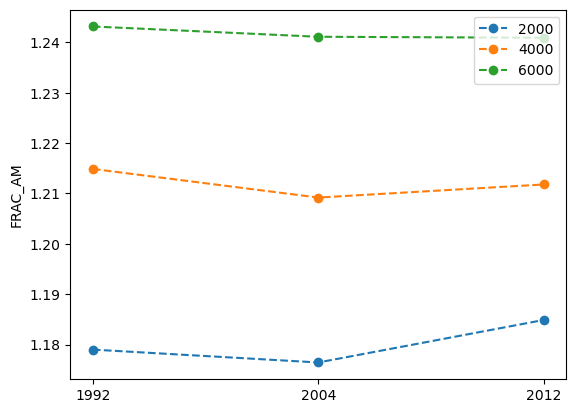

In [ ]:
stba.plot_metric("fractal_dimension_am")

In this case, the legend shows the buffer distance that corresponds to the plotted line.

## Spatiotemporal zonal grid analysis

Finally, we can explore the temporal evolution of landscape metrics over a single regular rectangular grid using the `SpatioTemporalZonalGridAnalysis` class:

In [ ]:
zone_width, zone_height = 2000, 2000  # in this case, in meters

stzga = pls.SpatioTemporalZonalGridAnalysis(
    input_filepaths, zone_width=zone_width, zone_height=zone_height, dates=years
)

Likewise with `ZonalAnalysis` we can also define the number of zones that we desire in each dimension by means of the `num_zone_rows` and `num_zone_cols` keyword arguments of the initialization method.

Again, the functionalities of `SpatioTemporalZonalGridAnalysis` are essentially the same as those of `SpatioTemporalZonalAnalysis` (and `SpatioTemporalBufferAnalysis`) reviewed above:

In [ ]:
class_metrics_df = stzga.compute_class_metrics_df(metrics=metrics)
class_metrics_df.head()

metric                    proportion_of_landscape edge_density  \
grid_cell class_val dates                                        
2         1         1992                 9.340659    24.725275   
                    2004                  9.89011    25.274725   
                    2012                12.087912     30.21978   
          2         1992                74.175824    47.252747   
                    2004                73.626374    47.802198   

metric                    fractal_dimension_am  
grid_cell class_val dates                       
2         1         1992              1.057659  
                    2004              1.063133  
                    2012              1.081621  
          2         1992              1.160231  
                    2004              1.160843